In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip3 install livelossplot

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as matimage
import cv2

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras import regularizers, optimizers

from livelossplot import PlotLossesKeras

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

import os
import time
import datetime
import glob

import plotly.express as px

In [4]:
SOURCE_PATH = '/content/drive/MyDrive/PetImages'

# os.listdir returns a list containing all files under the given path
start = time.time()
CAT_PATH = os.listdir(os.path.join(SOURCE_PATH, 'Cat'))
DOG_PATH = os.listdir(os.path.join(SOURCE_PATH, 'Dog'))

CAT_PATH = list(map(lambda x : os.path.join(SOURCE_PATH+"/Cat", x), CAT_PATH))
DOG_PATH = list(map(lambda x : os.path.join(SOURCE_PATH+"/Dog", x), DOG_PATH))
end = time.time()

print(f"{len(CAT_PATH)} cats img")
print(f"{len(DOG_PATH)} dogs img")
print(f'\n{end-start} sec.')

12500 cats img
12500 dogs img

114.97288393974304 sec.


In [ ]:
# Skip here (serach for '# From here on...')

In [ ]:
df = pd.DataFrame({"path":CAT_PATH+DOG_PATH,"label":[0]*len(CAT_PATH)+[1]*len(DOG_PATH)})
df.head()

,path,label
0,/content/drive/MyDrive/PetImages/Cat/8907.jpg,0
1,/content/drive/MyDrive/PetImages/Cat/9120.jpg,0
2,/content/drive/MyDrive/PetImages/Cat/8898.jpg,0
3,/content/drive/MyDrive/PetImages/Cat/9220.jpg,0
4,/content/drive/MyDrive/PetImages/Cat/9102.jpg,0


In [ ]:
df.shape

(25000, 2)

In [ ]:
def data_check():
    """
        check each image file for corrupted or missing
    """
    error = []
    start = time.time()
    for i in range(len(df)):
        try:                    # checks for corrupeted or missing image files
            if len(cv2.imread(df.iloc[i,0])) == 3:
                _ = 1
        except:
            print(i)
            error.append(df.iloc[i,0])
    end = time.time()
    print(f'\n{end-start} sec.')
    return error

In [ ]:
remove = data_check()

In [ ]:
df = df[~df["path"].isin(remove)]

In [ ]:
df.to_csv('/content/drive/MyDrive/PetImages/data.csv', index=False)

In [ ]:
# From here on...

In [5]:
df = pd.read_csv('/content/drive/MyDrive/PetImages/data.csv')

In [6]:
cd_names = ['Cat', 'Dog']
n_cats = len(df.loc[df['label']==0])
n_dogs = len(df.loc[df['label']==1])
n_images = [n_cats, n_dogs]
px.pie(names=cd_names, values=n_images).update_layout(width=300, height=300)

In [7]:
df

,path,label
0,/content/drive/MyDrive/PetImages/Cat/8907.jpg,0
1,/content/drive/MyDrive/PetImages/Cat/9120.jpg,0
2,/content/drive/MyDrive/PetImages/Cat/8898.jpg,0
3,/content/drive/MyDrive/PetImages/Cat/9220.jpg,0
4,/content/drive/MyDrive/PetImages/Cat/9102.jpg,0
...,...,...
24941,/content/drive/MyDrive/PetImages/Dog/10081.jpg,1
24942,/content/drive/MyDrive/PetImages/Dog/10045.jpg,1
24943,/content/drive/MyDrive/PetImages/Dog/10100.jpg,1
24944,/content/drive/MyDrive/PetImages/Dog/10619.jpg,1


In [8]:
df['path'][12475:12477]

12475    /content/drive/MyDrive/PetImages/Cat/10737.jpg
12476     /content/drive/MyDrive/PetImages/Dog/9142.jpg
Name: path, dtype: object

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['path'][11475:13477], df['label'][11475:13477], test_size=0.1, random_state=42)

df_train = pd.DataFrame({"path":X_train,"label":y_train})
df_test = pd.DataFrame({"path":X_test,"label":y_test})

df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [10]:
train_datagen = ImageDataGenerator(rescale=1 / 255.0, validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [11]:
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [12]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    #classes=["Cat", "Dog"],   # to comment ?
    class_mode="categorical", # "categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    #classes=["Cat", "Dog"],   # to comment ?
    class_mode="categorical", # "categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col="path",
    y_col=None, # "label"
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb", # to comment ?
    #classes=["Cat", "Dog"],
    class_mode=None, # "binary",
    batch_size=1,
    shuffle=False,
    seed=42
)

Found 1441 validated image filenames belonging to 2 classes.
Found 360 validated image filenames belonging to 2 classes.
Found 201 validated image filenames.


In [13]:
train_generator.filepaths[-4:]

['/content/drive/MyDrive/PetImages/Dog/9027.jpg',
 '/content/drive/MyDrive/PetImages/Cat/10319.jpg',
 '/content/drive/MyDrive/PetImages/Dog/9752.jpg',
 '/content/drive/MyDrive/PetImages/Dog/8979.jpg']

In [14]:
train_generator.classes[-4:]

[1, 0, 1, 1]

In [15]:
train_generator.class_indices

{'0': 0, '1': 1}

In [28]:
def prepare_model():
    # model = Sequential()
    # model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())
    # model.add(Dense(16, activation='relu'))
    # model.add(Dense(2, activation='sigmoid'))

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
    #model.add(Activation('relu'))
    # model.add(Conv2D(32, (3, 3)))
    # model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    return model

In [29]:
model = prepare_model()

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 activation_8 (Activation)   (None, 111, 111, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      36928     
                                                      

In [34]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=20)

In [35]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

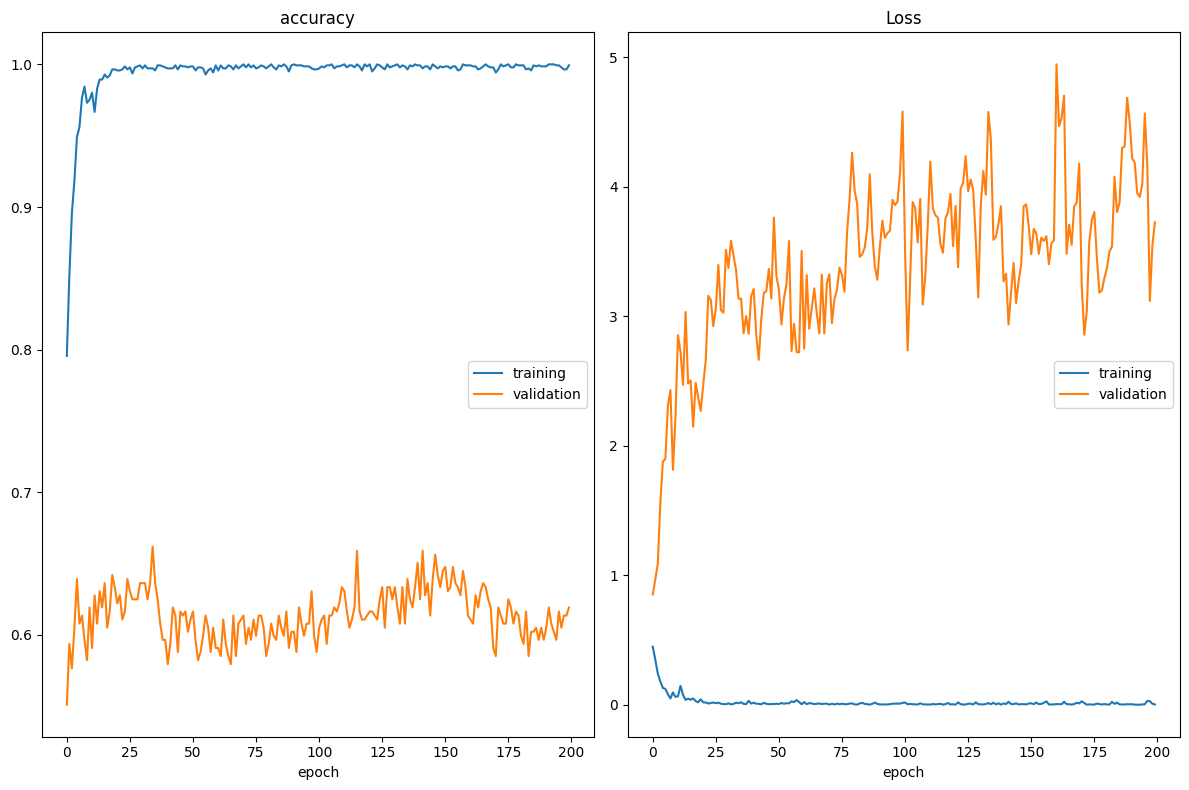

accuracy
	training         	 (min:    0.796, max:    1.000, cur:    0.999)
	validation       	 (min:    0.551, max:    0.662, cur:    0.619)
Loss
	training         	 (min:    0.000, max:    0.449, cur:    0.002)
	validation       	 (min:    0.852, max:    4.946, cur:    3.726)
45/45 [==============================] - 12s 263ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 3.7265 - val_accuracy: 0.6193


In [37]:
history = model.fit_generator(train_generator,
                              validation_data = valid_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_steps = STEP_SIZE_VALID,
                              use_multiprocessing = False,
                              epochs=200,
                              callbacks=[#es_callback,
                                         PlotLossesKeras()]
                              )

In [38]:
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

<ipython-input-38-22338f6c7a63>:1: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



[3.7385454177856445, 0.6193181872367859]

In [39]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

<ipython-input-39-e94155cdb30c>:4: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



201/201 [==============================] - 48s 241ms/step


In [42]:
predicted_class_indices=np.argmax(pred, axis=1)

In [43]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [44]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [45]:
results

,Filename,Predictions
0,/content/drive/MyDrive/PetImages/Dog/9776.jpg,1
1,/content/drive/MyDrive/PetImages/Cat/11433.jpg,0
2,/content/drive/MyDrive/PetImages/Dog/9082.jpg,1
3,/content/drive/MyDrive/PetImages/Cat/1035.jpg,0
4,/content/drive/MyDrive/PetImages/Dog/9132.jpg,1
...,...,...
196,/content/drive/MyDrive/PetImages/Dog/9403.jpg,1
197,/content/drive/MyDrive/PetImages/Dog/9882.jpg,1
198,/content/drive/MyDrive/PetImages/Cat/10188.jpg,0
199,/content/drive/MyDrive/PetImages/Cat/10852.jpg,1
